# Example 6

# Conducting a Frequency-Dependent Equivalent Linear Elastic Analysis (FDM-EQL) with pyStrata

This example will showcase pyStrata's capabilities in conducting a frequency-dependent site response analysis on a suite of ground motions.

## Outputs
<p style="margin-left: 20px;">
• <b>Theoretical Transfer Function</b><br>
• <b>Surface Response Spectra</b><br>
• <b>Predicted Surface Time Series</b> 
</p>

## Example Overview

1. <b>Generate a soil profile</b>   
   <span style="margin-left: 30px;">→ See Example 5 for more details.</span>   





2. <b>Load in ground motions used for analysis</b>  

3. <b>Run FDM-EQL site response analysis</b>  
   <span style="margin-left: 40px;"><b>3.1</b> Different options available in pystrata for calculating the strain spectrum </span>  
   <span style="margin-left: 60px;">→ Unsmoothed strain FAS scaled to maximum shear strain (Zalachoris, G., & Rathje, E., 2015)</span>   
   <span style="margin-left: 60px;">→ Konno-Ohmachi smoothing of strain FAS scaled to maximum shear strain  </span>

   <span style="margin-left: 40px;"><b>3.2</b> Available ouptuts:</span>     
   <span style="margin-left: 60px;">→ Maximum strain profile</span>   
   <span style="margin-left: 60px;">→ Damping spectra and Damping profile</span>   
   <span style="margin-left: 60px;">→ G/Gmax spectra and profile</span>   
   <span style="margin-left: 60px;">→ Computed transfer functions</span>   
   <span style="margin-left: 60px;">→ Response spectra</span>   
   <span style="margin-left: 60px;">→ Computed surface motion</span>     
 

  
  
 

# Step 1: Generate a Soil Profile

pyStrata allows the user several different methods in which to classify the damping (D) and shear modulus (G) properties of a soil at varying strains. For example, the user can select the Darendeli model (2001) and the Wang model (2022) to estimate soil damping.   
   
   Below, the soil profile for the Kik-Net site **KSRH09** will be analyzed.

An example pyStrata profile constructed using the Darendeli soil type:


In [1]:
import pystrata
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=40), 6, 90),
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=94), 4, 220),
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=209), 30, 440),
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=420), 32, 460),
        pystrata.site.Layer(pystrata.site.DarendeliSoilType(unit_wt=20.0, plas_index=15, ocr=1,stress_mean=634), 31, 530),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 20.0, None, 0.01), 0, 530),
    ]
)



# Step 2: Load in Ground Motion(s) for Analysis

The previous step included information exclusively related to setting up the site profile. The remainder of the example will use the *unscaled* Darendeli $D_{min}$ values for the soil damping profile.   

    
This example will use a single processed large-strain motion from the site KSRH09.
  

Total traces combined: 1
Total traces combined: 1


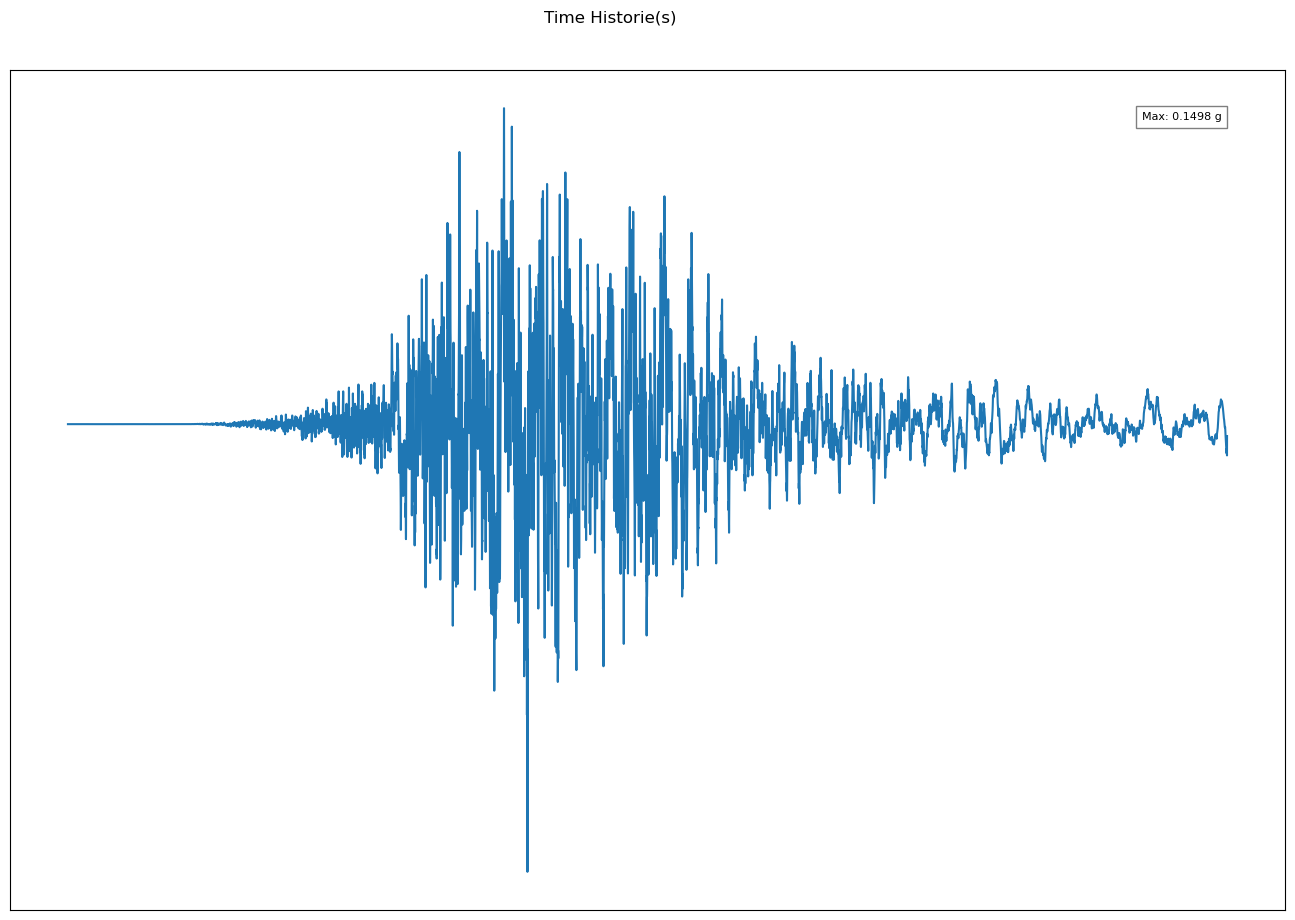

In [ ]:
# -------------------
# Create Obspy stream from MSEED file
# -------------------

from datools import signal_processing, site_response_small
base_stream = signal_processing.genstream("data/Example_6/base","MSEED")
surf_stream = signal_processing.genstream("data/Example_6/surface","MSEED")

# -------------------
# Convert Obspy Stream Object into pyStrata motion (see Example 2 for more information object definitions)
# -------------------

base_motion = site_response_small.convert_to_motion(base_stream,'EW1')
surf_motion = site_response_small.convert_to_motion(surf_stream,'Ew2')

# --------------------
# Plot the base motion
# --------------------


#This is the minimal plotting function, for full detail use 'plotstream()'
signal_processing.plotstream_minimal(base_stream)


# Step 3: Perform FDM-EQL Analysis

## Introduction

FDM-EQL analyses were created to address the limitations of EQL analysis at large strains. The intent is to calculate a shear strain frequency spectrum (i.e. strain FAS) that is then used to specify strain-compatible properties at each frequency. The figure below portrays this process (Zalachoris 2014,Zalachoris and Rathje 2015).  

In pyStrata, FDM-EQL is an iterative process that begins with the strains calculated via a traditional EQL analysis for initial strain estimates. The program then iterates with strains computed using frequency-dependent properties, updating the strain FAS and nonlinear soil properties until convergence is reached.
   
There are several ways in which to define the strain FAS that is used to define the frequency-dependent, strain-compatible properties in FDM-EQL analysis. These different methods will be explained in further detail in the following sections. 



Zalachoris (2014)


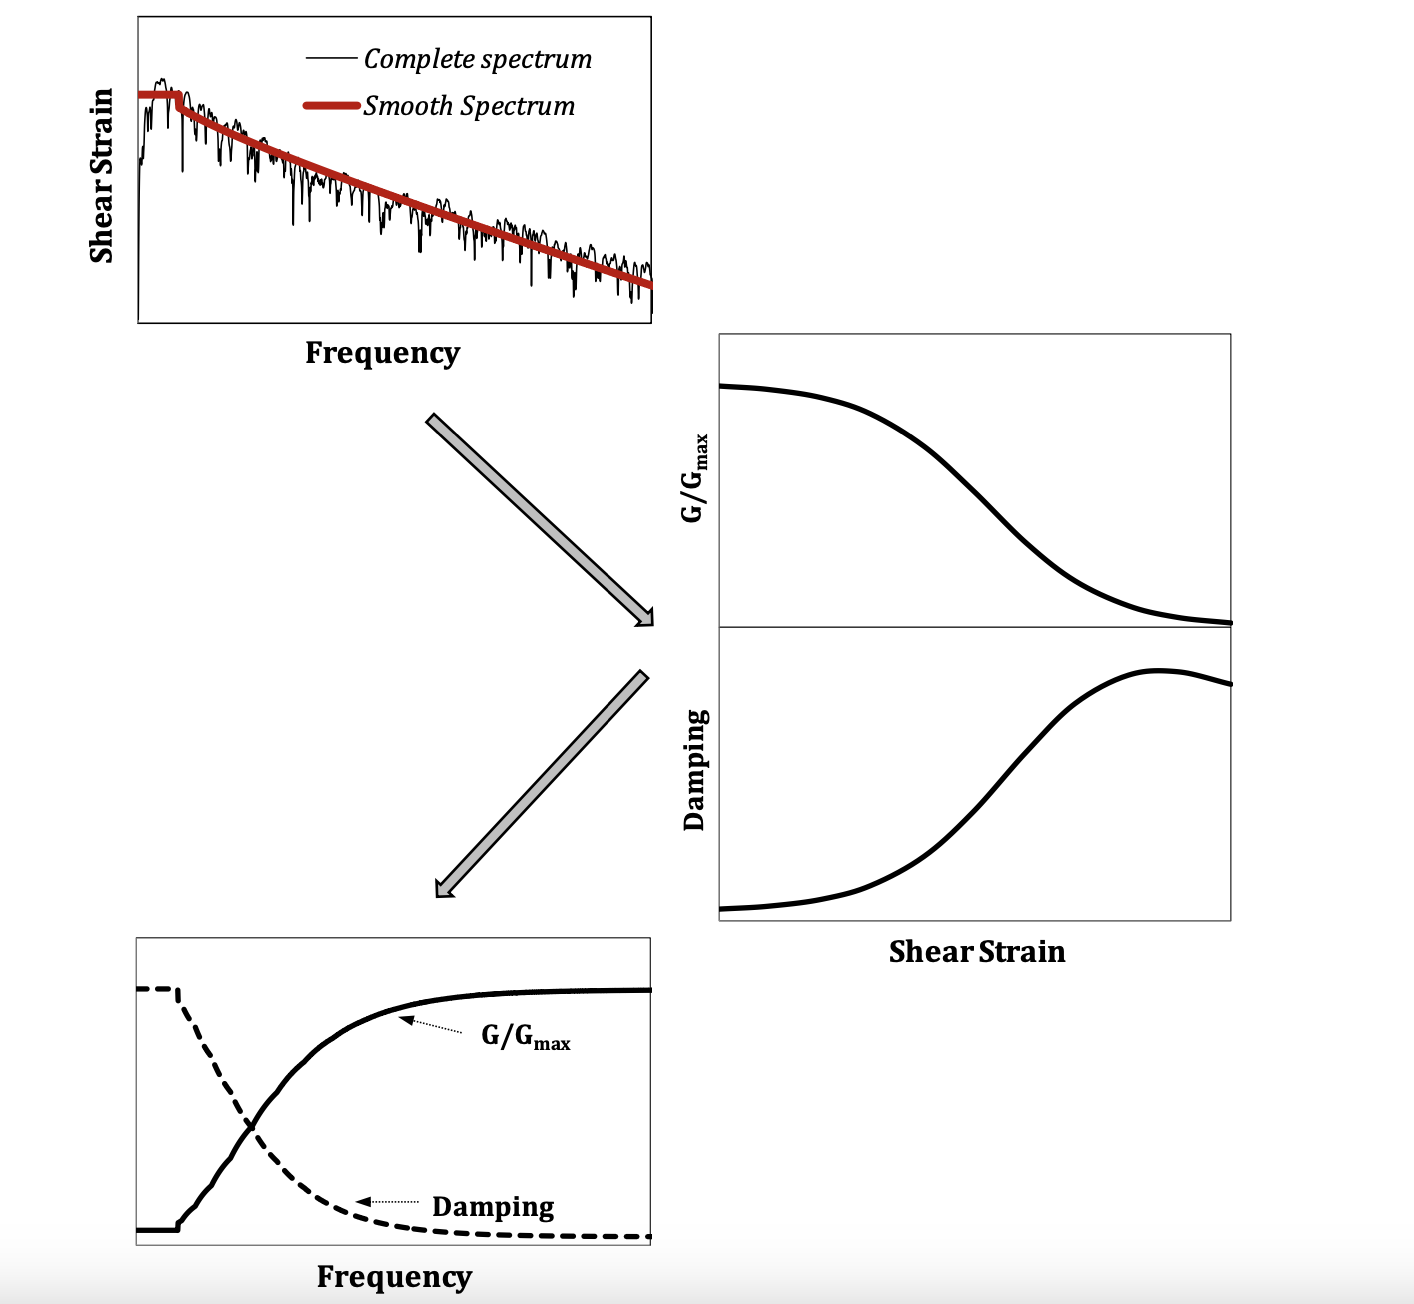

In [8]:
from IPython.display import Image
print("Zalachoris (2014)")
Image(filename='data/Example_6/image_1.png')


## Step 3.1: Different Methods for Calculating the Strain Spectrum

## Unsmoothed strain FAS (Zalachoris, G., & Rathje, E., 2015)



This approach utilizes the entire strain frequency spectrum, using the following procedure:


### 1. Calculate the Strain FAS within each layer

The strain Fourier Amplitude Spectrum (FAS) in each layer is computed as:
$$
\bigl|\mathrm{FAS}_{\gamma,i}(\omega)\bigr|
      \;=\;
      \bigl|H_{\gamma,i\mid a,\text{base}}(\omega)\bigr|\,
      \bigl|\mathrm{FAS}_{a,\text{base}}(\omega)\bigr|.
$$

where $H_{\gamma,i\mid a,\text{base}}(\omega)$ is the transfer function from the base acceleration to the target shear-strain location (i.e., the midpoint of layer i):

$$
H_{\gamma,i\mid a,\text{base}}(\omega)
      \;=\;
      \frac{\bigl|\mathrm{FAS}_{\gamma,i}(\omega)\bigr|}
           {\bigl|\mathrm{FAS}_{a,\text{base}}(\omega)\bigr|}\,.
$$

and 
- $\bigl|\mathrm{FAS}_{\gamma,i}(\omega)\bigr|$: Fourier-amplitude spectrum of the shear strain at the mid-height of layer $i$
- $|\text{FAS}_{a,\text{base}}(\omega)|$: Fourier-amplitude spectrum of the rock-outcrop acceleration applied at the base

### 2. Find the maximum strain in the time domain for each layer

$$
\text{Max shear strain} = \gamma(t)_{max}
$$

### 3. Scale the strain FAS

The frequency-dependent strain is then calculated as:

$$
\gamma(\omega) = \left[ \frac{\bigl|\mathrm{FAS}_{\gamma,i}(\omega)\bigr|}{\bigl|\mathrm{FAS}_{\gamma,i}(\omega)\bigr|_{\text{max}}} \right] \times \text{Max shear strain}
$$


## Konno-Ohmachi Smoothed Strain FAS

This method was developed by Dr. Albert Kottke for pyStrata. The process is generally quite similar when compared to the Zalachoris & Rathje (2014) model. However, instead of using the entire strain frequency spectra, this method apples a monotonic Konno-Ohmachi filter:


### 1. Calculate the Strain FAS from each layer   
(same as before)

### 2. Smooth the strain spectrum for each layer with a Konno-Ohmachi filter (optimal bandwidth is still uncertain)

### 3. Find the maximum strain in the time domain (after smoothing)
$$
\text{Max shear strain} = \gamma(t)_{max}
$$

where:

- effective strain ratio = 1 (usually 0.65 in EQL)

### 4. Normalize the strain FAS
$$
\gamma(\omega) = \left[ \frac{\bigl|\mathrm{FAS}_{\gamma,i}(\omega)\bigr|_{smoothed}}{\bigl|\mathrm{FAS}_{\gamma,i}(\omega)\bigr|_{\text{smoothed, max}}} \right] \times \text{Max shear strain}
$$

### 5. Moving **High to Low** frequency-wise, monotonically increase alongside the smoothed Strain FAS.


## Comparisons

The function below offers comparisons from the EQL, Zalachoris & Rathje (ZR), and "Konno-Ohmachi" (with a bandwidth of 20) methods for handling the strain frequency spectra (given a ground motion and profile):

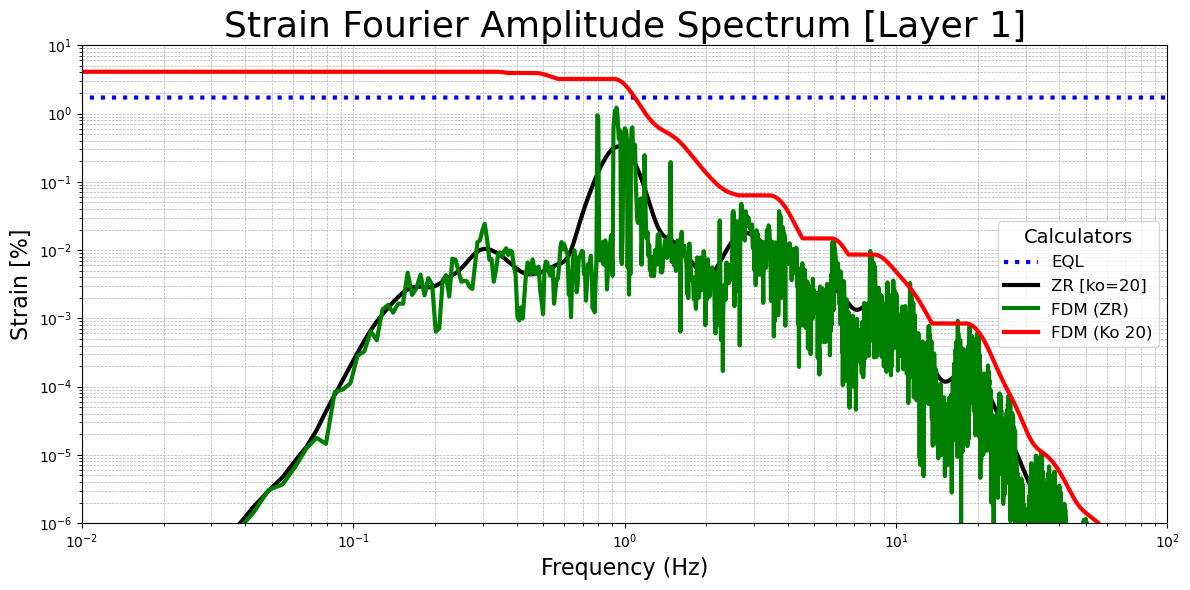

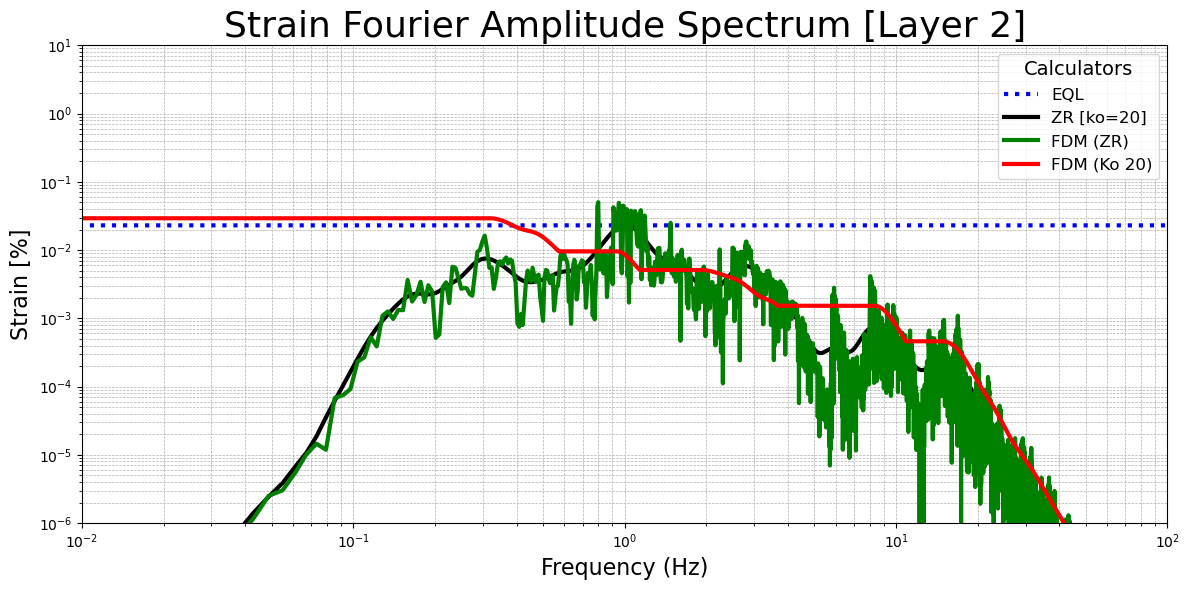

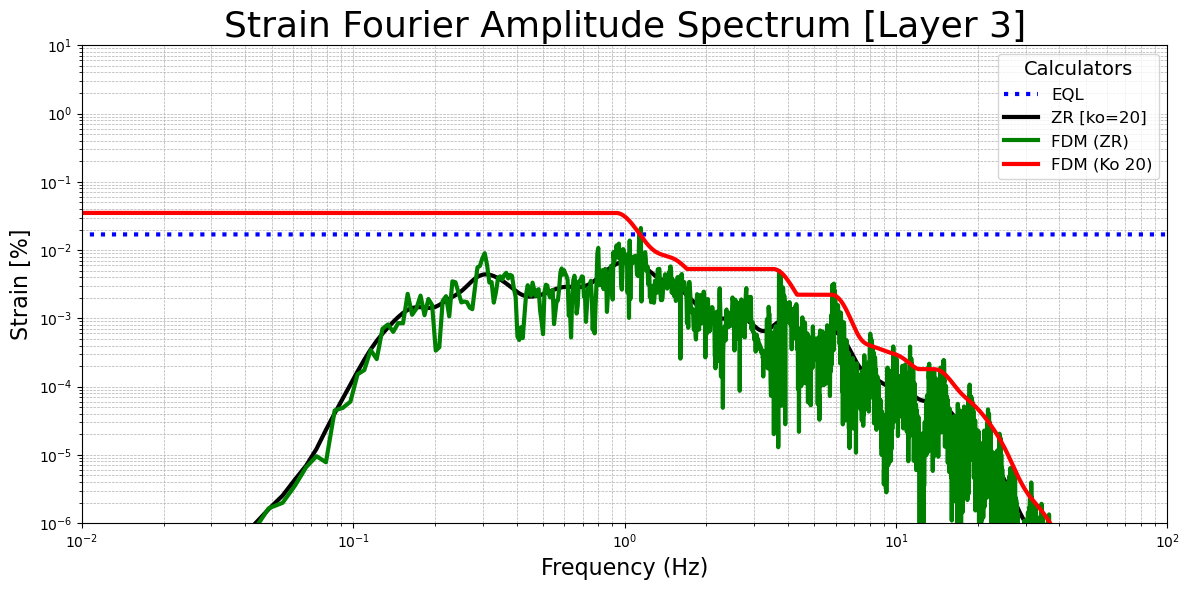

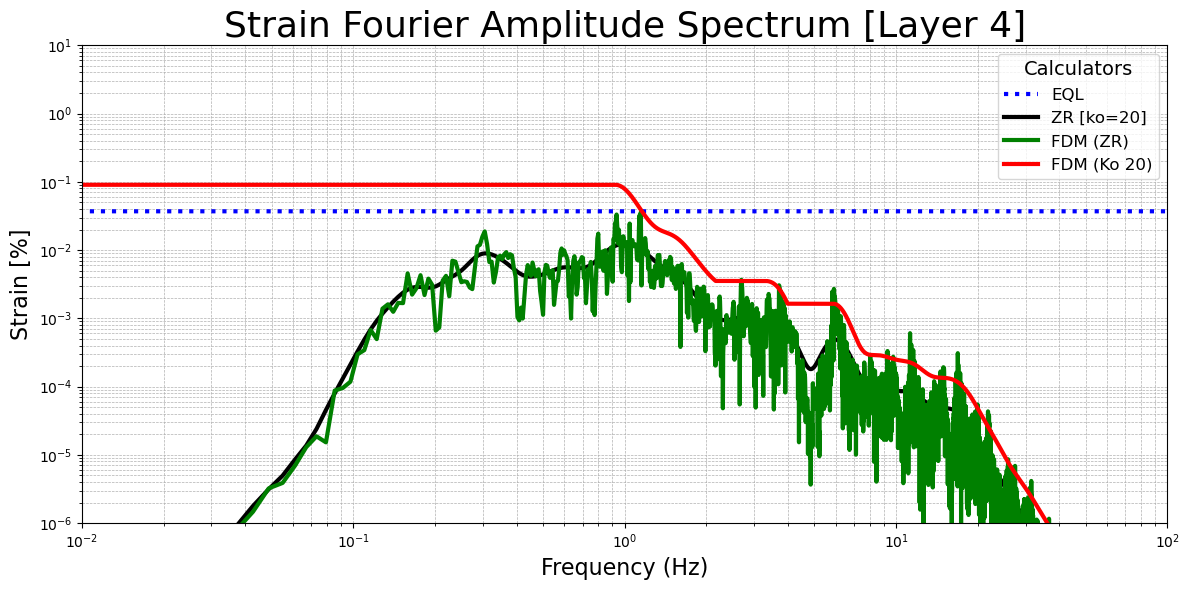

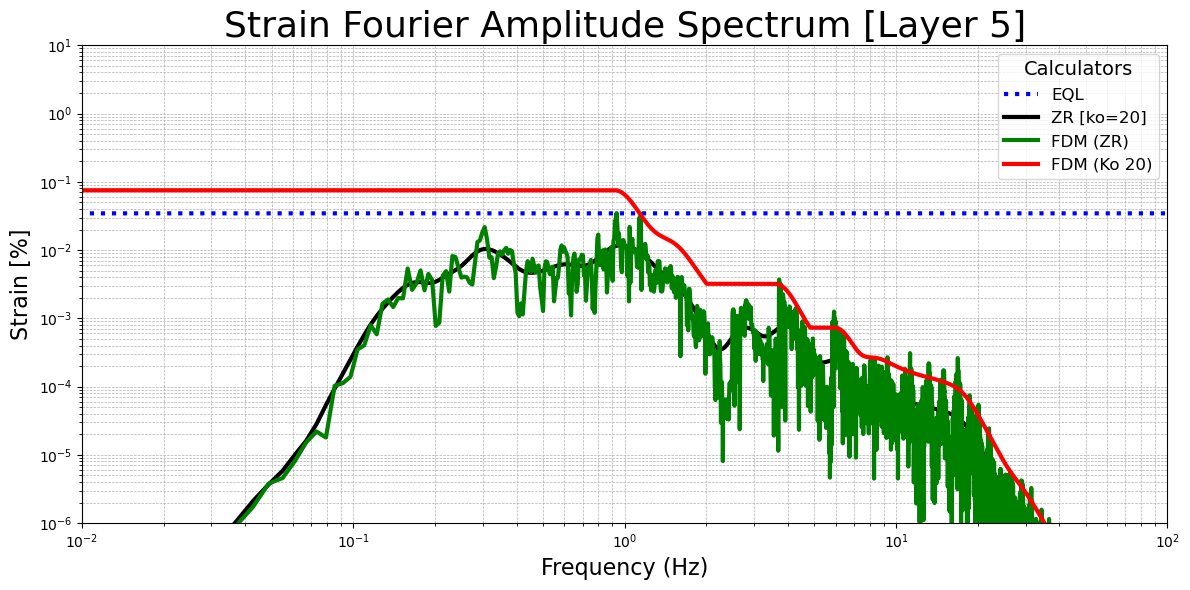

In [24]:
site_response_small.strain_levels_fdm(base_motion[0],profile)

# 3.2 FDM-EQL Site Response Outputs

Besides the differing strain FAS calculation methods, FDM-EQL analysis works analogous to EQL analysis in pyStrata. The interesting part of the analysis, is...the frequency dependent bit.   
   
The structure for the output code is just like in Example 2:

In [20]:
import numpy as np
freqs = np.logspace(-1, np.log10(50.0), num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
        ),
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            ko_bandwidth=30,
        ),
    ]
)

But the nonlinear soil properties change not only for each induced strain, but now alsohave strains that change at each frequency:

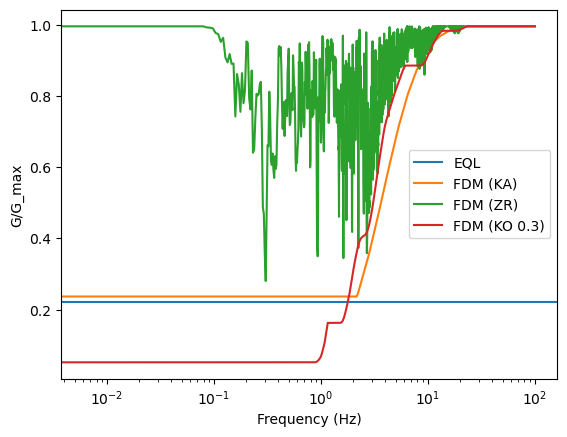

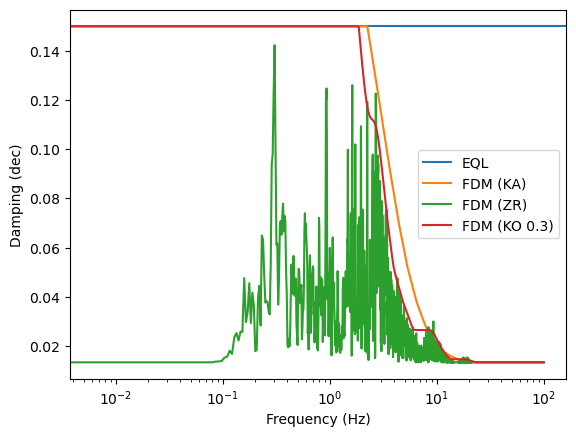

In [21]:
ts = base_motion[0]
calcs = [
    ("EQL", pystrata.propagation.EquivalentLinearCalculator()),
    (
        "FDM (KA)",
        pystrata.propagation.FrequencyDependentEqlCalculator(strain_ratio=0.65, method='ka02'),
    ),
    (
        "FDM (ZR)",
        pystrata.propagation.FrequencyDependentEqlCalculator(method='zr15'),
    ),
    (
        "FDM (KO 0.3)",
        pystrata.propagation.FrequencyDependentEqlCalculator(method='ko:20'),
    ),
]

properties = {}
for name, calc in calcs:
    calc(ts, profile, profile.location("outcrop", index=-1))
    outputs(calc, name)

    properties[name] = {
        key: getattr(profile[0], key) for key in ["shear_mod_reduc", "damping"]
    }



for key in properties["EQL"].keys():
    fig, ax = plt.subplots()

    for i, (k, p) in enumerate(properties.items()):
        if k == "EQL":
            ax.axhline(p[key], label=k, color=f"C{i}")
        else:
            ax.plot(ts.freqs, p[key], label=k, color=f"C{i}")

    ax.set(
        ylabel={"damping": "Damping (dec)", "shear_mod_reduc": "G/G_max"}[key],
        xlabel="Frequency (Hz)",
        xscale="log",
    )
    ax.legend()
     

The other standard outputs you would get from a site response analysis:

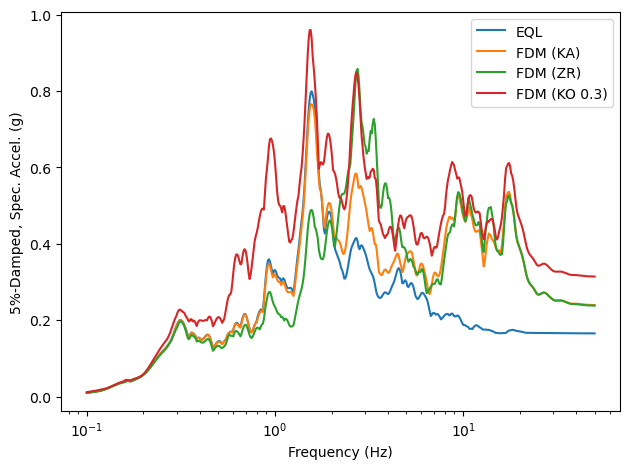

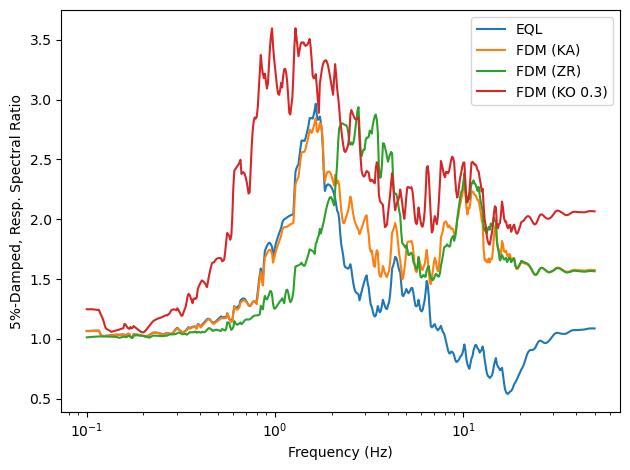

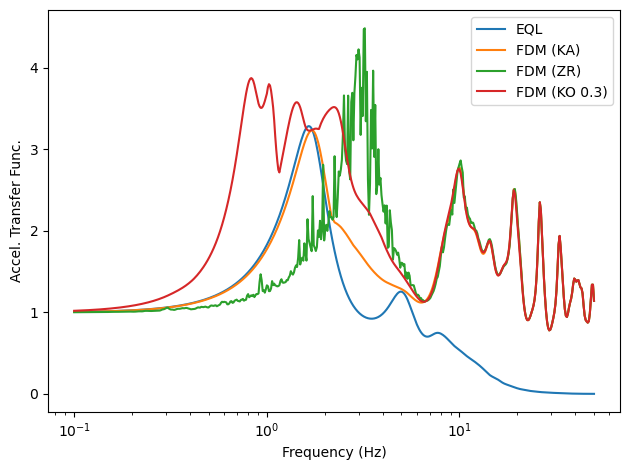

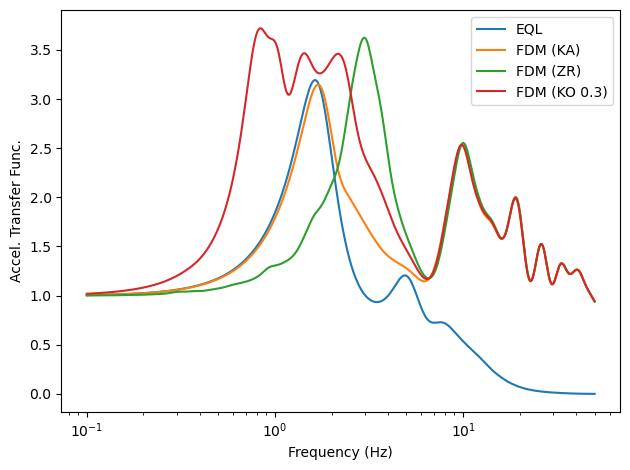

In [22]:
for output in outputs:
    fig, ax = plt.subplots()
    for name, refs, values in output.iter_results():
        ax.plot(refs, values, label=name)

    ax.set(xlabel=output.xlabel, xscale="log", ylabel=output.ylabel)
    ax.legend()
    fig.tight_layout()
     
